This code is to fit a spectrum as the sum of two models, and really it's a sum of four models. 

The goal is to map out the space of possible delta-Teff and spot coverage fractions allowed.
I suspect I will have to run this with a prior on either delta-Teff or fS to get something meaningful because of degeneracies

In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from emcee import EnsembleSampler
from multiprocessing import Pool
from corner import corner
from astropy.io import fits
from multiprocessing import Pool
from scipy import stats
from scipy import optimize
import numpy.random as random
import emcee
import corner
import random
from PyAstronomy import funcFit as fuf
from PyAstronomy import pyasl
from gaussfold import gaussfold as gf
from IPython.display import display, Math
from specutils.fitting import fit_continuum
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from astropy.modeling import models
import multiprocessing as mp
Pool = mp.get_context('fork').Pool
from dust_extinction.parameter_averages import F19
# define the model
ext = F19(Rv=3.1)


plt.rcParams['lines.linewidth']   =3
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] =2
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelweight']='semibold'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['axes.titleweight']='semibold'
plt.rcParams['axes.titlesize']=9

/Users/andrewmann/anaconda3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
def getspec(teffs,spectra, inteff): ##  for now other parameters are fixed
    loc = np.where(teffs == inteff)
    above = np.min(np.where(teffs >= inteff))
    below = np.max(np.where(teffs < inteff))
    if np.size(below) < 1 or np.size(above) < 1:
        return(-np.inf)
    
    spec1 = np.squeeze(spectra[:,above])
    spec2 = np.squeeze(spectra[:,below])
    weight = (inteff-teffs[below])/(teffs[above]-teffs[below])
    spec = (1.-weight)*spec2 + weight*spec1
    #else:
    #    spec = np.squeeze(spectra[:,loc])
    return(spec)

## this will take two temperatures (spot and surf) 
##and a coverage fraction (fS) 
## and output the relevant spectrum
def doublespec(teffs,spectra, teff1,teff2,fS):
    spec1 = getspec(teffs,spectra,teff1)
    spec2 = getspec(teffs,spectra,teff2)
    spec = spec1*(1-fS) + spec2*fS
    return(spec)

In [3]:
#def readin_data(data,data2,order,trim):
#return igspec_diva0, igwave, igspec, igspec_a0, igspec_vega, igspec_dividecont, snr
    
# plt.plot(igwave[index,:],igspec_diva0[index,:])
# plt.xlim(wrange[0],wrange[1])
# plt.tight_layout()
# plt.ylim(1e6,4e6)
# plt.show()
# plt.plot(igwave[index,:],igspec[index,:])
# plt.xlim(wrange[0],wrange[1])
# plt.ylim(1,2e4)
# plt.tight_layout()
# plt.show()

# 
# print(np.nanmedian(fracerr[index,:]))
# plt.plot(igwave[index,:],fracerr[index,:])
# plt.xlim(wrange[0],wrange[1])
# plt.ylim(0,0.2)
# plt.tight_layout()
# plt.show()

# plt.plot(igwave[index,:],igspec_a0[index,:])
# plt.xlim(wrange[0],wrange[1])
# plt.ylim(1,1e4)
# plt.tight_layout()
# plt.show()

#plt.plot(igwave[index,:],igspec_dividecont[index,:])
#plt.xlim(wrange[0],wrange[1])
#plt.ylim(2e6,4e6)
#plt.tight_layout()
#plt.show()

In [4]:
def resample_model(modelwave,modelspectra,igrinswave):
    #modelspec1 = doublespec(modelteff, modelspectra, 3540,2800,0.2)
    #modelspec2= doublespec(modelteff, modelspectra, 3540,2800,0.5)
    #modelspec3 = doublespec(modelteff, modelspectra, 3540,2800,0.8)
    #for ii in x:
    #    print(ii)
    #    igrinswave = igwave[ii,:]
    #    ll = np.where((modelwave > np.min(igrinswave))&(modelwave < np.max(igrinswave)))
    #    plt.plot(modelwave,modelspec3/np.median(modelspec3[ll]),label='80% spots',alpha=0.7)
    #    plt.plot(modelwave,modelspec2/np.median(modelspec2[ll]),label='50% spots',alpha=0.7)
    #    plt.plot(modelwave,modelspec1/np.median(modelspec1[ll]),label='20% spots',alpha=0.7)
    #    plt.xlim(np.min(igrinswave)+10,np.max(igrinswave)-10)
    #    plt.ylim(0.3,1.4)
    #    plt.legend()
    #    plt.show()

    ## resample model spectra
    from gaussfold import gaussfold as gf
    newlambda = np.array(igrinswave)
    newmodel = np.zeros((np.size(newlambda),np.size(modelteff)))
    for i in range(0,np.size(modelteff)):
        tmp = np.array(modelspectra[:,i])
        interpfunc = interpolate.interp1d(modelwave, tmp, kind='linear',fill_value="extrapolate")
        modelspec_new = interpfunc(newlambda)
        modelspec_new = gf(newlambda, modelspec_new, np.median(newlambda)/45000)
        newmodel[:,i] = modelspec_new

    modelspectra = newmodel
    modelwave = newlambda
    #modelspec = doublespec(modelteff, modelspectra, 3540,3520,0.01)
    #modelspec/=np.median(modelspec[np.where((modelwave > wrange[0])&(modelwave < wrange[1]))])
    #modelspec2 = doublespec(modelteff, modelspectra, 3540,2800,0.7)
    #modelspec2/=np.median(modelspec2[np.where((modelwave > wrange[0])&(modelwave < wrange[1]))])
    #plt.plot(modelwave,modelspec,alpha=0.5,label='nospot')
    #plt.plot(modelwave,modelspec2,alpha=0.5,label='spot')
    #plt.xlim(wrange[0],wrange[1])
    #plt.ylim(0.5,1.2)
    #plt.legend()
    #plt.show()
    return modelspectra, modelwave



In [5]:
# fig, ax = plt.subplots()
# fig.set_size_inches(6, 3)

# alpha = 0.8
# ## here let's make some example spectra to show off why this method works
# spec3 = doublespec(modelteff,modelspectra,3540,2800,0.8)
# plt.plot(modelwave/1e4,spec3/np.median(spec3),label='80% spots',alpha=alpha,color='green')
# spec2 = doublespec(modelteff,modelspectra,3540,2800,0.5)
# plt.plot(modelwave/1e4,spec2/np.median(spec2),label='50% spots',alpha=alpha,color='blue')
# spec1 = doublespec(modelteff,modelspectra,3540,2800,0.2)
# plt.plot(modelwave/1e4,spec1/np.median(spec1),label='20% spots',alpha=alpha,color='black')

# plt.tight_layout
# ax.set_xlim(np.min(modelwave/1e4)+0.003,np.max(modelwave/1e4)-0.003)
# #plt.xscale('log')
# #plt.yscale('log')
# ax.set_ylim(np.min(spec3/np.median(spec3)),np.max(spec3/np.median(spec3)))
# plt.legend()
# ax.set_ylabel(r'Normalized Flux')
# ax.set_xlabel(r'Wavelength ($\mu m$)')
# plt.tight_layout()
# plt.savefig('Example_spots_highres'+str(order)+'.pdf')


In [6]:
## the likelihood for fitting IGRINS data
## 1) Tsurf
## 2) Tspot 
## 3) small lambda offsets (or RV)
## 4) flux cal errors??
## 5) fS
## 6) broadening
## we can ignore reddening
#define functions for MCMC
def ln_prior(theta):
    Tsurf, Tspot, fS, a, b, loff, f, broad = theta
    if (a<0.5) or (a>1.5) or (broad < 0.01) or (broad > 1) or (loff < -3) or (loff > 3) or (Tspot < 1000) or (Tspot > 4000) or (Tsurf < 1000) or (Tsurf > 4000) or fS < 0.0 or fS > 1.0 or f < 0 or f > 0.1 or Tspot>(Tsurf-100):
        return -np.inf
    return 0

## warning, wavelengths for model spectra and observational data must match
def ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obserr, cutoff):
    Tsurf, Tspot, fS, a, b, loff, f, broad = theta
    modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
    newwav = wav + loff
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift = interpfunc(newwav)
    ## vsini broadening
    modelspec_smooth = gf(wav, modelspec_shift, broad)##pyasl.fastRotBroad(newwav, modelspec_shift, 0.0, broad)
    
    modelspec_norm = np.array(modelspec_smooth)/np.mean(modelspec_smooth)
    obsspec_norm = np.array(obsspec)/np.mean(obsspec)
    obsspec_err_norm = np.array(obserr)/np.mean(obsspec)
    
    normalizer = (a+b*(wav-np.nanmean(wav)))
    obsspec_norm*=normalizer
    obsspec_err_norm*=normalizer
    
    modelspec_norm = modelspec_norm[cutoff:np.size(wav)-cutoff]
    obsspec_norm = obsspec_norm[cutoff:np.size(wav)-cutoff]
    obsspec_err_norm = obsspec_err_norm[cutoff:np.size(wav)-cutoff]
    wav = wav[cutoff:np.size(wav)-cutoff]
    #plt.plot(wav,modelspec_norm)
    #plt.plot(wav,obsspec_norm)
    #plt.show()
    #plt.plot(wav,obsspec_norm/obsspec_err_norm)
    #plt.show()
    
    diff = modelspec_norm - obsspec_norm
    s_squared = np.square(obsspec_err_norm) + np.square(f*obsspec_norm)
    p = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(diff) / (2. * s_squared)) 
    #tmp = np.sort(p)
    output = np.sum(np.log(p))
    return output

def ln_posterior(theta, modelteff, modelspectra, wav, obsspec, obserr, cutoff ):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obserr, cutoff )
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

In [7]:
def inialize_walkers(igrinswave,igrinsspec,igrinserr,modelspectra,modelteff,cutoff,nwalkers):
    mwav = np.array(list(igrinswave))
    ospec = np.array(list(igrinsspec))
    oerr = np.array(list(igrinserr))
    mspec = np.array(list(modelspectra))
    mteff = np.array(list(modelteff))
    initial_guesses = [3500, 2500, 0.5, 1, 0.0, 0.56, 0.01, 0.2]

    pos0 = []
    ##print('initializing walkers:')
    counter = 0
    randomizer = [200, 200, 0.2, 0.001, 0.0001, 0.01, 0.01, 0.01]
    while len(pos0) < nwalkers:
        counter+=1
        if counter > 5000:
            print('failed to initialize walkers, check the initial conditions and/or input data')
            break 
        trial = initial_guesses + randomizer * np.random.randn(ndim)
        lp = ln_posterior(trial,mteff,mspec,mwav,ospec,oerr,cutoff)
        if np.isfinite(lp):
            pos0.append(trial)

    #plt.plot(mwav,ospec)
    #plt.show()
    return mwav, ospec, oerr, mspec, mteff, pos0

In [8]:
def run_mcmc(nwalkers,ndim,mteff,mspec,mwav,ospec,oerr,nthreads,order,cutoff):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(mteff,mspec,mwav,ospec,oerr,cutoff), threads=nthreads)
    sampler.run_mcmc(pos0, nsteps,progress=True)

    print('saving output')
    np.save('Multispec_igrins'+str(order)+'_chain.npy', np.array(sampler.chain))
    np.save('Multispec_igrins'+str(order)+'_prob.npy', np.array(sampler.lnprobability))
    np.save('Multispec_igrins'+str(order)+'_accept.npy',np.array(sampler.acceptance_fraction))

    return sampler

In [9]:
def make_plots(sampler):
    #print('walker plot')
    labels = [r'$T_{\rm{surf}}$ (K)',r'$T_{\rm{spot}}$ (K)',r'$f_S$ (%)',r'$a$',r'$b$',r'$\lambda_{\rm{off}}$ ($\AA$)',r'$\sigma_f$ (%)',r'Broadening (\AA)']
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain(discard=burn)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    plt.savefig('Walkers_specfit_igrins'+str(order)+'.pdf')

    #print('Corner plots')
    flat = np.array(sampler.get_chain(discard=burn, thin=thin, flat=True))
    flat_samples = np.array(flat)
    flat_samples[:,2]*=100
    flat_samples[:,6]*=100
    fig = corner.corner( 
        flat_samples, labels=labels, show_titles=True,
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.4f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
    );
    plt.savefig('Corner_spec_igrins'+str(order)+'.pdf')
    ###### trimmed corner #####
    flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
    flat_samples[:,2]*=100
    prob = sampler.get_log_prob(flat=True,thin=thin,discard=burn)
    trimmed_flat = flat_samples[:,0:3]
    trimmed_labels = labels[0:3]
    fig = corner.corner( 
        trimmed_flat, labels=trimmed_labels, show_titles=False,
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.1f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
    );
    plt.savefig('Corner_spec_trim_igrins'+str(order)+'.pdf')


    flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
    labels = [r'$T_{\rm{surf}}$ (K)',r'$T_{\rm{spot}}$ (K)',r'$f_S$ (\%)',r'$a$',r'$b$',r'$\lambda_{\rm{off}}$ ($\AA$)',r'$\sigma_f$ (\%)',r'Broadening (\AA)']
    ## report best-fit parameters, and save to a file
    best = []
    f = open("results_"+str(order)+".txt","w")
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        #if i == 0:
        #    mcmc = np.percentile(np.exp(flat_samples[:, i]), [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
        f.write(labels[i]+','+str(mcmc[1])+','+str(q[0])+','+str(q[1])+' \n')
        b = flat_samples[np.where(prob == np.max(prob)),i]
        if np.size(b) > 1:
            b = np.squeeze(b)[0]
        f.write(str(b)+'\n')
        best.append(b)
    f.close()
    print(best)
    
    plt.show()
    plt.clf()
    return best   

In [10]:
## parameters we might want to adjust
order = 7
band = 'K'
trim = 5
minsnr = 25
cutoff = 40
if band == 'K':
    hdul = fits.open('SDCK_20170316_0102.spec_a0v.fits')
    hdul.info()
    hdr = hdul[1].header
    data = hdul[1].data
    hdul2 = fits.open('SDCK_20170316_0102.variance.fits')
    data2 = hdul2[0].data
if band == 'H':
    hdul = fits.open('SDCH_20170316_0102.spec_a0v.fits')
    hdul.info()
    hdr = hdul[1].header
    data = hdul[1].data
    hdul2 = fits.open('SDCH_20170316_0102.variance.fits')
    data2 = hdul2[0].data
    
igspec_diva0 = hdul[0].data
igwave = hdul[1].data*1e4
igspec = hdul[2].data
igspec_a0 = hdul[3].data
igspec_vega = hdul[4].data
igspec_dividecont = hdul[5].data
index = order
fracerr = (np.sqrt(data2/igspec**2 + igspec_a0/igspec_a0**2))
snr = 1./fracerr
norders = np.size(snr[:,0])
modelpath = '/Users/andrewmann/Dropbox/Radii/Models_K233_Feb2020.fits'
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data
lambda0 = 4000
nlambda = 210001
dlambda = 0.1
modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
modelteff = np.squeeze(data['teff'])
modellogg = np.squeeze(data['logg'])
modelafe = np.squeeze(data['a_fe'])
modelmh = np.squeeze(data['metal'])
modelspectra = np.squeeze(data['spectrum'])

Filename: SDCK_20170316_0102.spec_a0v.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPEC_DIVIDE_A0V    1 PrimaryHDU     274   (2048, 25)   float64   
  1  WAVELENGTH    1 ImageHDU       273   (2048, 25)   float64   
  2  TGT_SPEC      1 ImageHDU       273   (2048, 25)   float32   
  3  A0V_SPEC      1 ImageHDU       273   (2048, 25)   float32   
  4  VEGA_SPEC     1 ImageHDU       273   (2048, 25)   float64   
  5  SPEC_DIVIDE_CONT    1 ImageHDU       273   (2048, 25)   float64   


/Users/andrewmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


Filename: /Users/andrewmann/Dropbox/Radii/Models_K233_Feb2020.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 13650065E, 65E, 65E, 65E, 65E, 65E]   


Order, SNR:
0 0.5549179
Order, SNR:
1 11.675115
Order, SNR:
2 19.900515
Order, SNR:
3 24.541483
Order, SNR:
4 27.887817


100%|██████████| 10000/10000 [08:10<00:00, 20.38it/s]


saving output


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[3997.108317939117, 2696.3658916585723, 33.876734619802725, 1.0343628804574723, -0.00025185275365556065, 2.90847346431736, 0.03316490912185258, 0.6597941810755806]


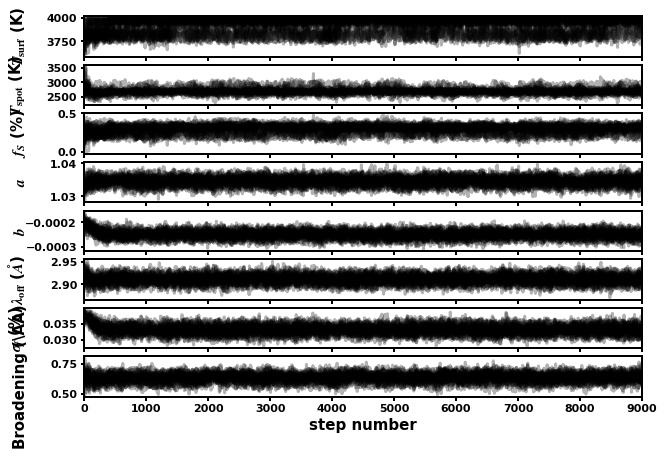

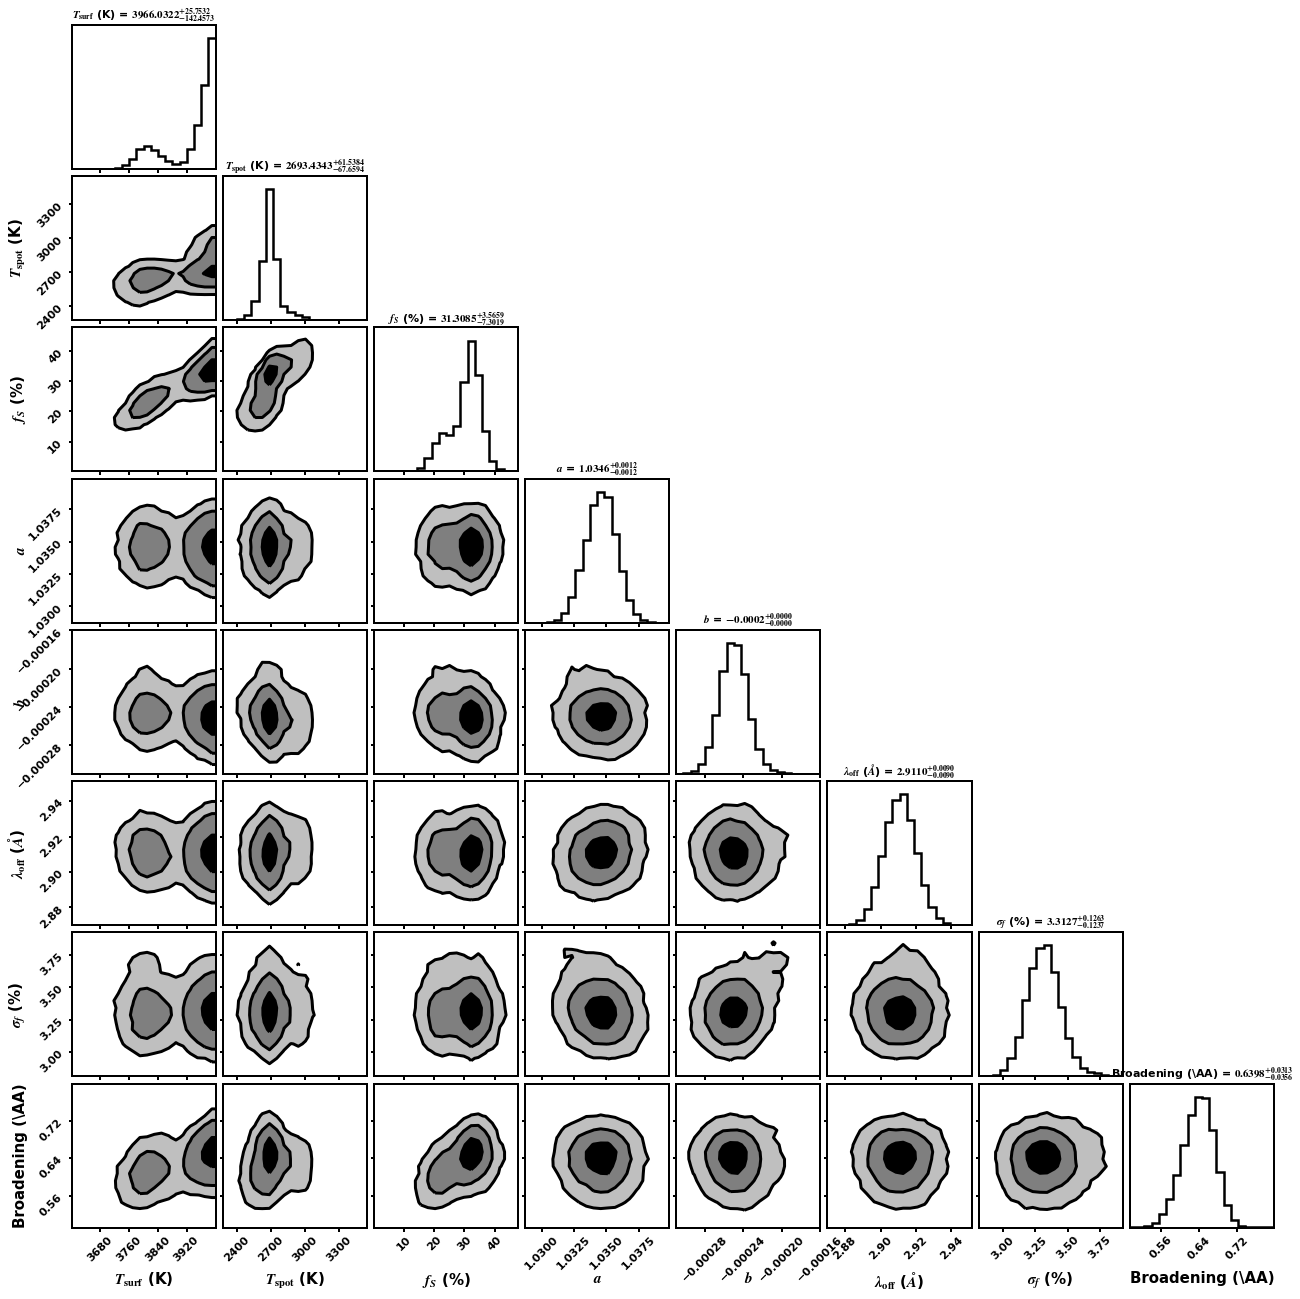

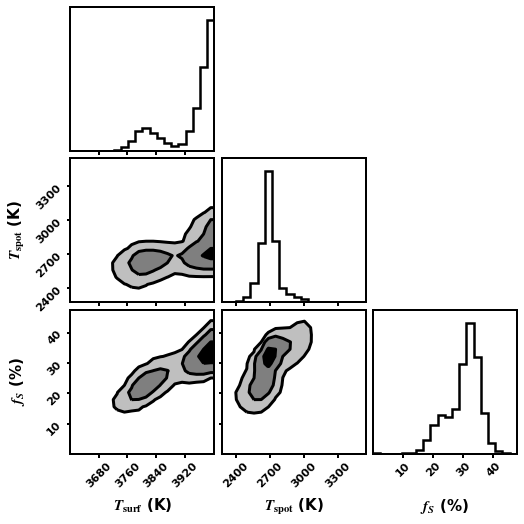

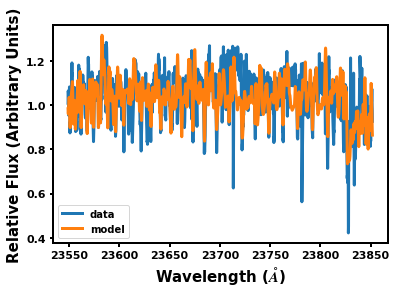

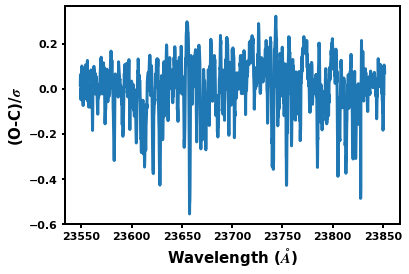

Order, SNR:
5 32.037216


/Users/andrewmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
 85%|████████▍ | 8498/10000 [06:46<01:01, 24.28it/s] 

In [ ]:
nsteps = 10000
burn = 1000
thin = 1
nwalkers, ndim = 32, 8
nthreads = 12
for order in range(0,27):
    if order < norders:
        ordersnr = np.nanmean(snr[order,:])
        print('Order, SNR:')
        print(order,ordersnr)
        if ordersnr > minsnr:
            wrange = [np.min(igwave[order,:])+trim,np.max(igwave[order,:])-trim]
            igrinswave = np.array(igwave[order,:])
            igrinsspec = np.array(igspec_diva0[order,:])
            igrinserr = np.array(igrinsspec*fracerr[order,:])
            tmp = igrinsspec/np.nanmedian(igrinsspec)
            ll = np.where((np.isfinite(igrinserr))&(np.isfinite(igrinswave))&(np.isfinite(igrinsspec))&(igrinserr>0)&(tmp<1.2))
            igrinsspec = np.squeeze(igrinsspec[ll])
            igrinserr = np.squeeze(igrinserr[ll])
            igrinswave = np.squeeze(igrinswave[ll])
            ll = np.where((igrinswave > wrange[0])&(igrinswave < wrange[1]) )
            igrinsspec = igrinsspec[ll]
            igrinserr = igrinserr[ll]
            igrinswave = igrinswave[ll]

            modelspectra, modelwave = resample_model(modelwave,modelspectra,igrinswave) 
            mwav, ospec, oerr, mspec, mteff, pos0 = inialize_walkers(igrinswave,igrinsspec,igrinserr,modelspectra,modelteff,cutoff,nwalkers)
            sampler = run_mcmc(nwalkers,ndim,mteff,mspec,mwav,ospec,oerr,nthreads,order,cutoff)
            best = make_plots(sampler)
            
            ## make a plot showing the best fit and residual
            wav = np.array(mwav)
            Tsurfb, Tspotb, fSb, ab, bb, loffb, fb, broadb = best
            modelspec = doublespec(mteff,mspec,Tsurfb,Tspotb,fSb)
            newwav = wav + loffb
            interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
            modelspec_shift = interpfunc(newwav)
            ## vsini broadening
            modelspec_smooth = gf(wav, modelspec_shift, broadb)
            modelspec_norm = np.array(modelspec_smooth)/np.mean(modelspec_smooth)
            obsspec_norm = np.array(ospec)/np.mean(ospec)
            obsspec_err_norm = np.array(oerr)/np.mean(oerr)
            normalizer = (ab+bb*(wav-np.nanmean(wav)))
            obsspec_norm*=normalizer
            obsspec_err_norm*=normalizer
            #print(normalizer)
            modelspec_norm = modelspec_norm[cutoff:np.size(wav)-cutoff]
            obsspec_norm = obsspec_norm[cutoff:np.size(wav)-cutoff]
            obsspec_err_norm = obsspec_err_norm[cutoff:np.size(wav)-cutoff]
            wav = wav[cutoff:np.size(wav)-cutoff]
            
            
            plt.plot(wav,obsspec_norm,label='data')
            plt.plot(wav,modelspec_norm,label='model')
            plt.xlabel(r'Wavelength ($\AA$)')
            plt.ylabel(r'Relative Flux (Arbitrary Units)')
            plt.legend()
            plt.savefig('bestfit_igrins'+str(order)+'.pdf')
            plt.show()
            plt.clf()
            
            
            plt.plot(wav,(obsspec_norm-modelspec_norm)/obsspec_err_norm)
            plt.xlabel(r'Wavelength ($\AA$)')
            plt.ylabel(r'(O-C)/$\sigma$')
            plt.savefig('bestfit_igrins_resid'+str(order)+'.pdf')
            plt.show()
            plt.clf()


In [ ]:
#plt.plot(wav,obsspec_norm,label='data')
#plt.plot(wav,modelspec_norm,label='model')
#plt.xlabel(r'Wavelength ($\AA$)')
#plt.ylabel(r'Relative Flux (Arbitrary Units)')
#plt.legend()
#plt.show()